In [3]:
# from PIL import Image, ImageChops, ImageEnhance
import PIL
import sys, os.path

In [12]:
%matplotlib inline
import os, sys
import skimage.io
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

In [69]:
class Photo:
    def __init__(self, im_array):
        self.im_array = im_array

    @classmethod
    def fromfilename(cls, filename):
        im_array = skimage.io.imread(filename)
        return cls(im_array)
    
    def show(self, title=None):
        fig = plt.figure(figsize=(10,5))
        a = fig.add_subplot(1,1,1)
        if (title == None):
            title = self.im_name
        a.set_title(title)
        imgplot = plt.imshow(self.im_array, cmap=cm.Greys_r)
        plt.show()
        
    def error_level_analysis(self, quality):
        resaved = "./resaved_tmp.jpg"
        image = PIL.Image.fromarray(self.im_array)
        image.save(resaved, "JPEG", quality=quality)
        resaved_im = PIL.Image.open(resaved)
        
        ela_im = ImageChops.difference(image, resaved_im)
        extrema = ela_im.getextrema()
        max_diff = max([ex[1] for ex in extrema])
        scale = 255.0 / max_diff
        
        ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
        os.remove(resaved)
        return Image(np.array(ela_im))   

In [79]:
from skimage.filters import gabor_kernel
from scipy import ndimage as ndi
from sklearn.cluster import KMeans

In [106]:
class objectDetection:
    blue = [0, 0, 125]
    gamma = 2.2
    
    def __init__(self, img):
        self.img = img
        self.segs = slic(img, n_segments=200, sigma=10, enforce_connectivity=True)
        self.clust = KMeans(n_clusters=3)
    
    # prepare filter bank kernels
    def compute_kernels(self):
        kernels = []
        for theta in range(4):
            # orientation of texture
            theta = theta / 4. * np.pi 
            # width of the Gaussian envelope
            for sigma in (3,): #(1, 3, 5): 
                for frequency in (0.05, 0.25):
                    kernel = np.real(gabor_kernel(frequency, theta=theta, sigma_x=sigma, sigma_y=sigma))
                    kernels.append(kernel)
        self.kernels = kernels
    
    def compute_feats(self, image, segs_mask):
        feats = np.zeros(len(self.kernels), dtype='float32')
        for k, kernel in enumerate(self.kernels):
            filtered = ndi.convolve(image, kernel, mode='wrap')
            feats[k] = filtered[segs_mask].mean()
#             feats[k, 1] = filtered[segs_mask].var()
        return feats

    def make_features(self):
        segs_amount = self.segs.max()
        features = np.zeros(segs_amount, 
            dtype=[ 
                 ('rmean', 'float32')
                ,('gmean', 'float32') 
                , ('bmean', 'float32')
                ,('rvar', 'float32')
                , ('gvar', 'float32')
                , ('bvar', 'float32')
                ,('luminance','float32')
#                 ,('luma', 'float32')
                ,('gabor_filters', 'float32', len(self.kernels))
                  ])
        img_grey = skimage.color.rgb2grey(self.img)
        for k in range(segs_amount):
            r, g, b = self.img[self.segs == k, 0], self.img[self.segs == k, 1], self.img[self.segs == k, 2]
            features['rmean'][k] = np.mean(r)
            features['gmean'][k] = np.mean(g)
            features['bmean'][k] = np.mean(b)
            features['rvar'][k] = np.var(r)
            features['gvar'][k] = np.var(g)
            features['bvar'][k] = np.var(b)
            features['gabor_filters'][k] = self.compute_feats(img_grey, self.segs == k)
        features['luminance'] = 0.3*features['rmean'] + 0.3*features['gmean'] + 0.3*features['bmean']
#         features['luma'] = 0.2126*features['rmean']**self.gamma + 0.7152**features['gmean']**self.gamma + 0.0722*features['bmean']**self.gamma
        self.features = features

    def getObject(self, objMark):
        result = self.img.copy()
        self.img[:,:,0] = 0
        self.img[:,:,2] = 0
        self.compute_kernels()
        self.make_features()
        features = self.features
        vectors = features.view(('float32', len(features.dtype.names) - 1 + len(self.kernels)))  # 
        clust = self.clust
        clust.fit(vectors)
        mask = clust.labels_
        for n_seg in range(self.segs.max()):
            if mask[n_seg] != objMark:
                result[self.segs == n_seg] = self.blue
        return result

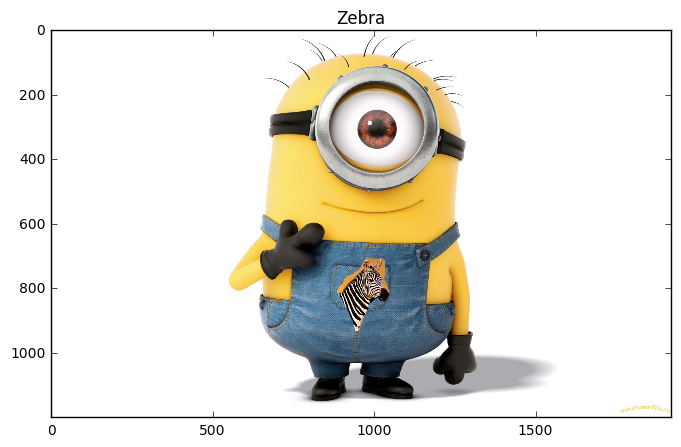

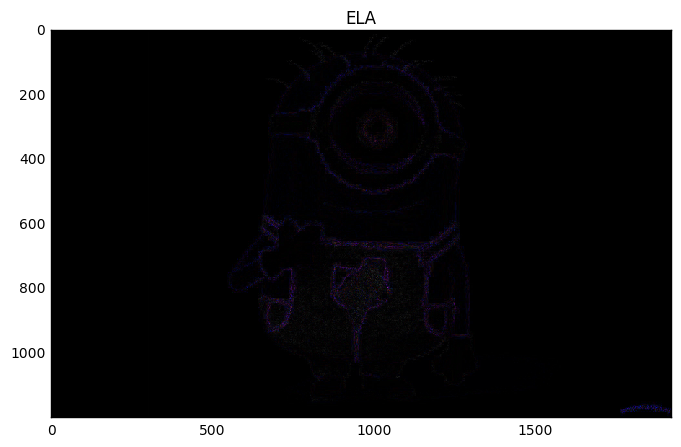

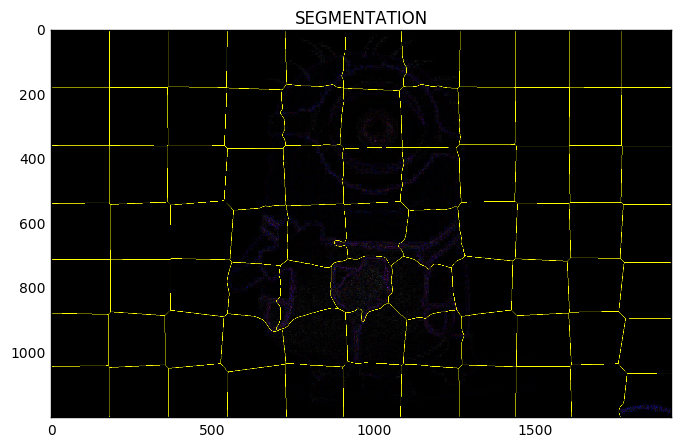

In [86]:
i = Photo.fromfilename("C://Users\Lobkov\Pictures\pic_z.jpg")
i.show("Zebra")
ela = i.error_level_analysis(70)
ela.show("ELA")
ela_slic = slic(ela.im_array, n_segments=70, sigma=7, enforce_connectivity=True)
ela_slic_im = Photo(mark_boundaries(ela.im_array, ela_slic))
ela_slic_im.show("SEGMENTATION")
# z = objectDetection(ela.im_array)
# seg_photo = Photo(z.getObject(0))
# seg_photo.show("KMeans")

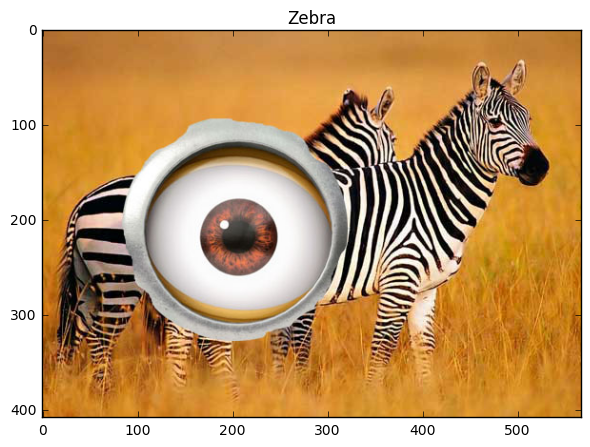

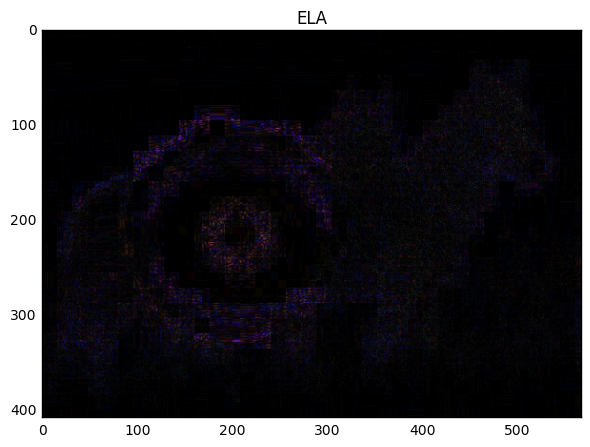

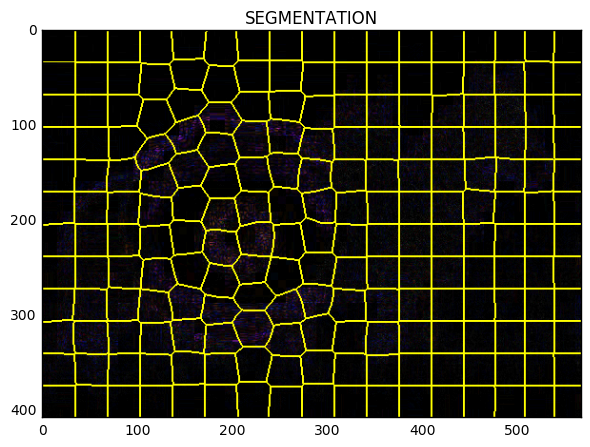

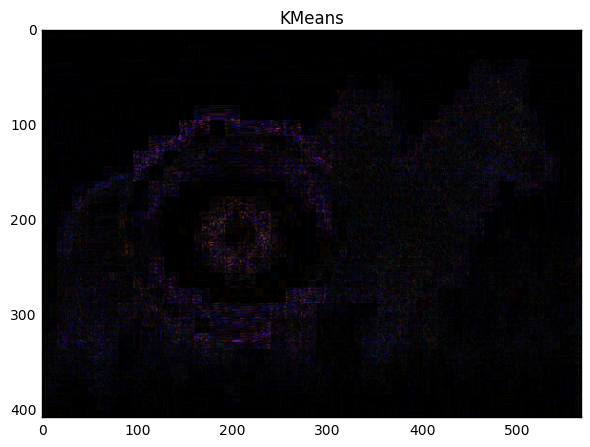

In [118]:
i = Photo.fromfilename("C://Users\Lobkov\Pictures\zebra_eye.jpg")
i.show("Zebra")
ela = i.error_level_analysis(90)
ela.show("ELA")

ela_slic = slic(ela.im_array, n_segments=200, sigma=10, enforce_connectivity=True)
ela_slic_im = Photo(mark_boundaries(ela.im_array, ela_slic))
ela_slic_im.show("SEGMENTATION")

z = objectDetection(ela.im_array)
seg_photo = Photo(z.getObject(i))
seg_photo.show("KMeans")